In the above problem, in addition to methods using Neural Network models or LLMs models, the problem of A binary class label of whether the molecule binds to the protein is a problem that can use machine learning models. to solve part of the above problem. In this problem, I am using 5 models: Random Forest, Decision Tree, Catboost, XGboost and KNN to compare on a data set including 180,000 rows data on the train set. Because the training set is very heavy (about more than 50 gb), we will extract the parquest file using duckdb to put it into machine learning models and use the model with the highest performance to compare the results.

### Importing Libraries

In [1]:
!pip install rdkit
!pip install duckdb


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install pandas
import duckdb
import pandas as pd

train_path = '../datasets/train.parquet'
test_path = '../datasets/test.parquet'

con = duckdb.connect()

df = con.query(f"""(SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 0
                        ORDER BY random()
                        LIMIT 90000)
                        UNION ALL
                        (SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 1
                        ORDER BY random()
                        LIMIT 90000)""").df()

con.close()


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


### Dataset

In [3]:
df.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,17564856,CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,CCSCCN.Cl,Nc1n[nH]c2c(Cl)cc([N+](=O)[O-])cc12,CCSCCNc1nc(Nc2n[nH]c3c(Cl)cc([N+](=O)[O-])cc23...,BRD4,0
1,35754223,COc1ccc(C[C@H](NC(=O)OCC2c3ccccc3-c3ccccc32)C(...,Nc1ccc(CC2COC(=O)N2)cc1,Nc1nc(Cl)c2[nH]cnc2n1,COc1ccc(C[C@H](Nc2nc(Nc3ccc(CC4COC(=O)N4)cc3)n...,HSA,0
2,131347475,O=C(N[C@H]1CC[C@@H](C(=O)O)C1)OCC1c2ccccc2-c2c...,Cl.NCCNC(=O)c1ccn[nH]1,Nc1nccs1,O=C(NCCNc1nc(Nc2nccs2)nc(N[C@H]2CC[C@@H](C(=O)...,sEH,0
3,252829877,O=C(O)C[C@@H](Cc1ccccc1Cl)NC(=O)OCC1c2ccccc2-c...,CC1(CCCCN)OCCO1,COC1(OC)CC(CN)C1,COC1(OC)CC(CNc2nc(NCCCCC3(C)OCCO3)nc(N[C@@H](C...,sEH,0
4,73933672,O=C(NC(CCc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,Nc1ccc(OC(F)F)cc1,Cc1ccsc1CN,Cc1ccsc1CNc1nc(Nc2ccc(OC(F)F)cc2)nc(NC(CCc2ccc...,HSA,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   id                     180000 non-null  int64 
 1   buildingblock1_smiles  180000 non-null  object
 2   buildingblock2_smiles  180000 non-null  object
 3   buildingblock3_smiles  180000 non-null  object
 4   molecule_smiles        180000 non-null  object
 5   protein_name           180000 non-null  object
 6   binds                  180000 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 9.6+ MB


### No. of unique proteins in dataset

In [5]:
df['protein_name'].unique()

array(['BRD4', 'HSA', 'sEH'], dtype=object)

In [6]:
!pip install seaborn
!pip install matplotlib
import seaborn as sns
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


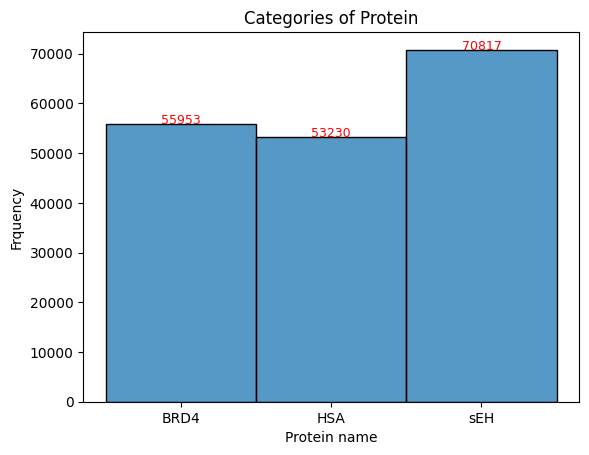

In [7]:
sns.histplot(df['protein_name'])
plt.xlabel("Protein name")
plt.ylabel("Frquency")
plt.title("Categories of Protein")


for bar in plt.gca().patches:
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                  f'{int(bar.get_height())}', 
                  ha='center', color='red', fontsize=9)
    
plt.show()


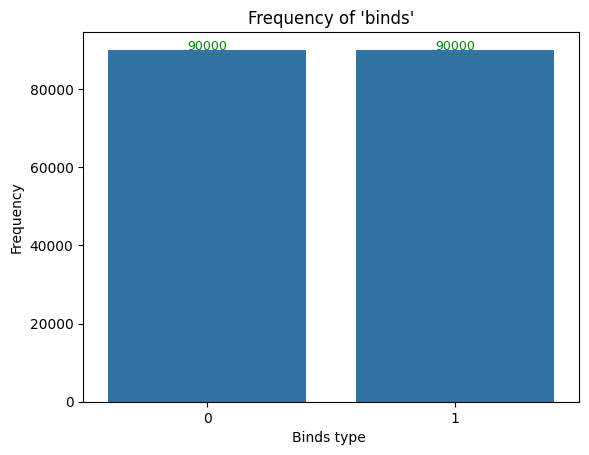

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='binds', data=df)

plt.xlabel("Binds type ")
plt.ylabel("Frequency")


plt.title("Frequency of 'binds'")


for p in plt.gca().patches:
    plt.gca().text(p.get_x() + p.get_width()/2, p.get_height(), 
                   f'{int(p.get_height())}', 
                   ha='center', color='green', fontsize=9)


plt.show()

## Visualize the chemical formula of samples

We will visualize the substances in the data in 2D and 3D formats to see the molecular formulas and the building blocks that make them up.

In [9]:
import re
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

formula: 
CCSCCNc1nc(Nc2n[nH]c3c(Cl)cc([N+](=O)[O-])cc23)nc(NC(CC(C)C)C(=O)N[Dy])n1
molecular structure visualization of this formula:


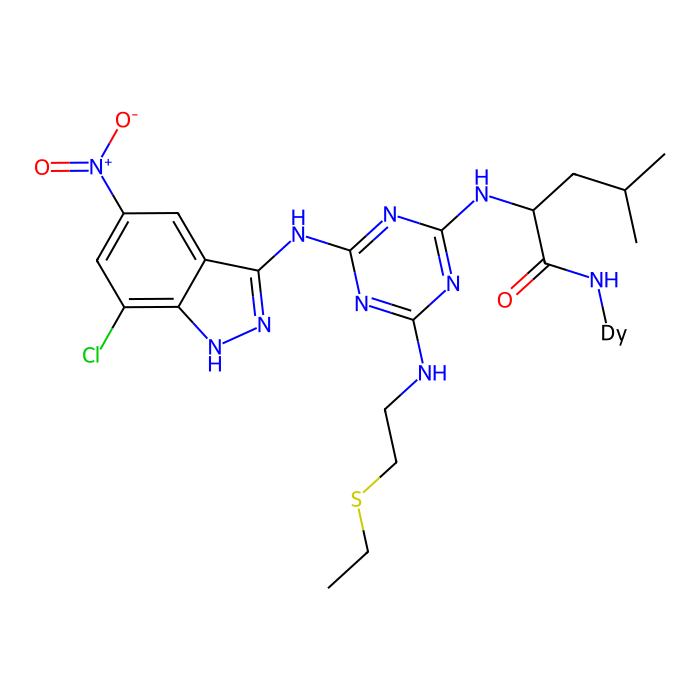

In [10]:
# Code to visualize the first molecule in molecule_smiles col in 2D.

# Convert Dask Series to pandas Series and extract the first SMILES string
first_smiles = df['molecule_smiles'].iloc[0]

print("formula: ")
print(first_smiles)

# Convert the SMILES string to a molecule object
first_molecule = Chem.MolFromSmiles(first_smiles)

# Draw and display the molecule
print("molecular structure visualization of this formula:")
Draw.MolToImage(first_molecule, size=(700, 700))

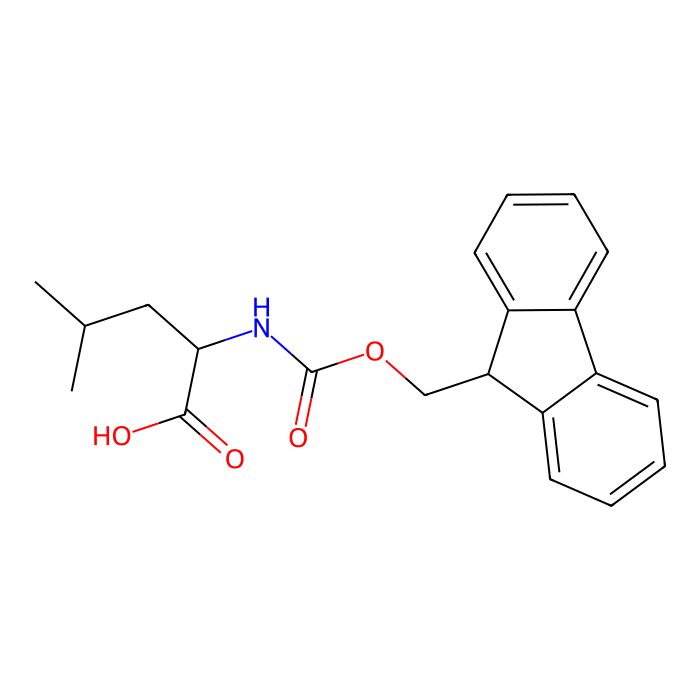

In [11]:
# Code to visualize the first molecule in molecule_smiles col in 2D.

#Visualize the chemical formula of building block 1
first_smiles = df['buildingblock1_smiles'].iloc[0]

# Convert the SMILES string to a molecule object
first_molecule = Chem.MolFromSmiles(first_smiles)

# Draw and display the molecule
Draw.MolToImage(first_molecule, size=(700, 700))

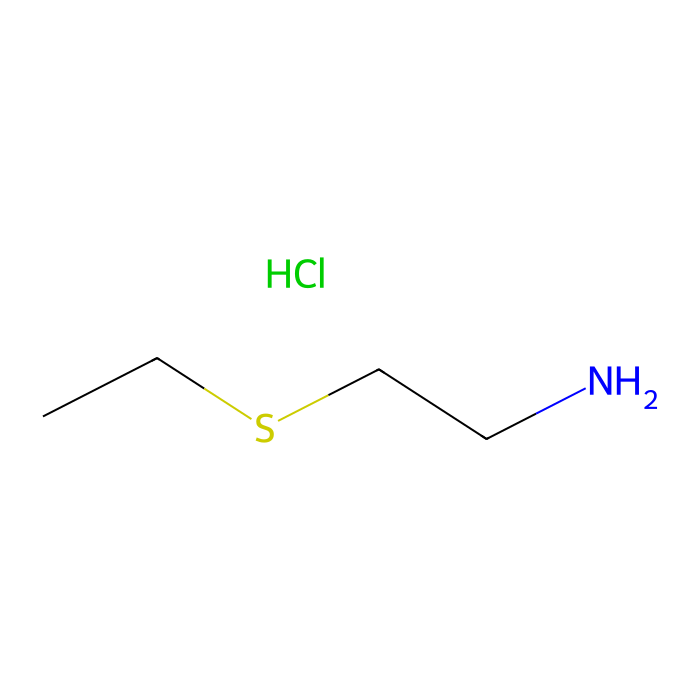

In [12]:
# Visualize the chemical formula of building block 2
first_smiles = df['buildingblock2_smiles'].iloc[0]

# Convert the SMILES string to a molecule object
first_molecule = Chem.MolFromSmiles(first_smiles)

# Draw and display the molecule
Draw.MolToImage(first_molecule, size=(700, 700))

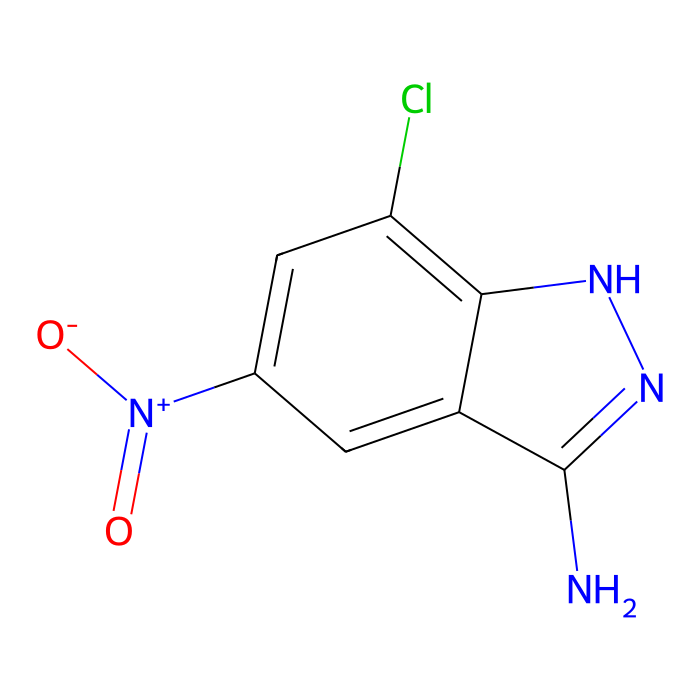

In [13]:
# Visualize the chemical formula of building block 3
first_smiles = df['buildingblock3_smiles'].iloc[0]

# Convert the SMILES string to a molecule object
first_molecule = Chem.MolFromSmiles(first_smiles)

# Draw and display the molecule
Draw.MolToImage(first_molecule, size=(700, 700))

In [14]:
!pip install py3Dmol


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [15]:
# Code to visualize the first molecule in molecule_smiles col in 3D.
import py3Dmol

# Convert the SMILES string to an RDKit molecule object
first_molecule_smiles = df['molecule_smiles'].iloc[0]
first_molecule = Chem.MolFromSmiles(first_molecule_smiles)
print("molecule formula before:",first_molecule)
# 2. Add hydrogen atoms to the molecule
first_molecule = Chem.AddHs(first_molecule)

print("molecule formula after:",first_molecule)
# Embed the molecule in 3D space
AllChem.EmbedMolecule(first_molecule)

# Visualize the molecule in 3D using Py3Dmol
view = py3Dmol.view(width=800, height=600)
pdb_block_molecule = Chem.MolToPDBBlock(first_molecule)
view.addModel(pdb_block_molecule, 'pdb')
view.setStyle({'stick': {}})
view.zoomTo()
view.show()

molecule formula before: <rdkit.Chem.rdchem.Mol object at 0x31d95b450>
molecule formula after: <rdkit.Chem.rdchem.Mol object at 0x31d95b060>


[13:43:14] UFFTYPER: Unrecognized charge state for atom: 34
[13:43:14] UFFTYPER: Unrecognized atom type: Dy5+3 (34)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Data Processing and training model

Instead of calculating the accuracy score, I'm be going with calculating mAP score: minimum average precision score which provides a better analysis for this dataset specifically as it provides the mean of average precision value(AP) of a class for all classes and hence it is a perfect measuring parameter of the model performance in terms of predicting the "binds probability" of a molecule

### Info abt ECFP ###

Molecular fingerprints are representations that encode key functionalities and properties of chemical compounds. They were originally designed for substructure search in databases, but later gained popularity for similarity searching and molecule clustering.

Extended-connectivity fingerprints (ECFPs) are a type of molecular fingerprint specifically designed for predicting and analyzing molecular activity and properties. First introduced in 2000, they have since been widely adopted across various fields. (Interestingly, they are conceptually similar to convolutional operations: like the convolution operator in CNNs that apply the same function in all directions before global pooling, ECFPs use iterative circular hashing to capture local chemical environments before proceeding to a global pooling step.)

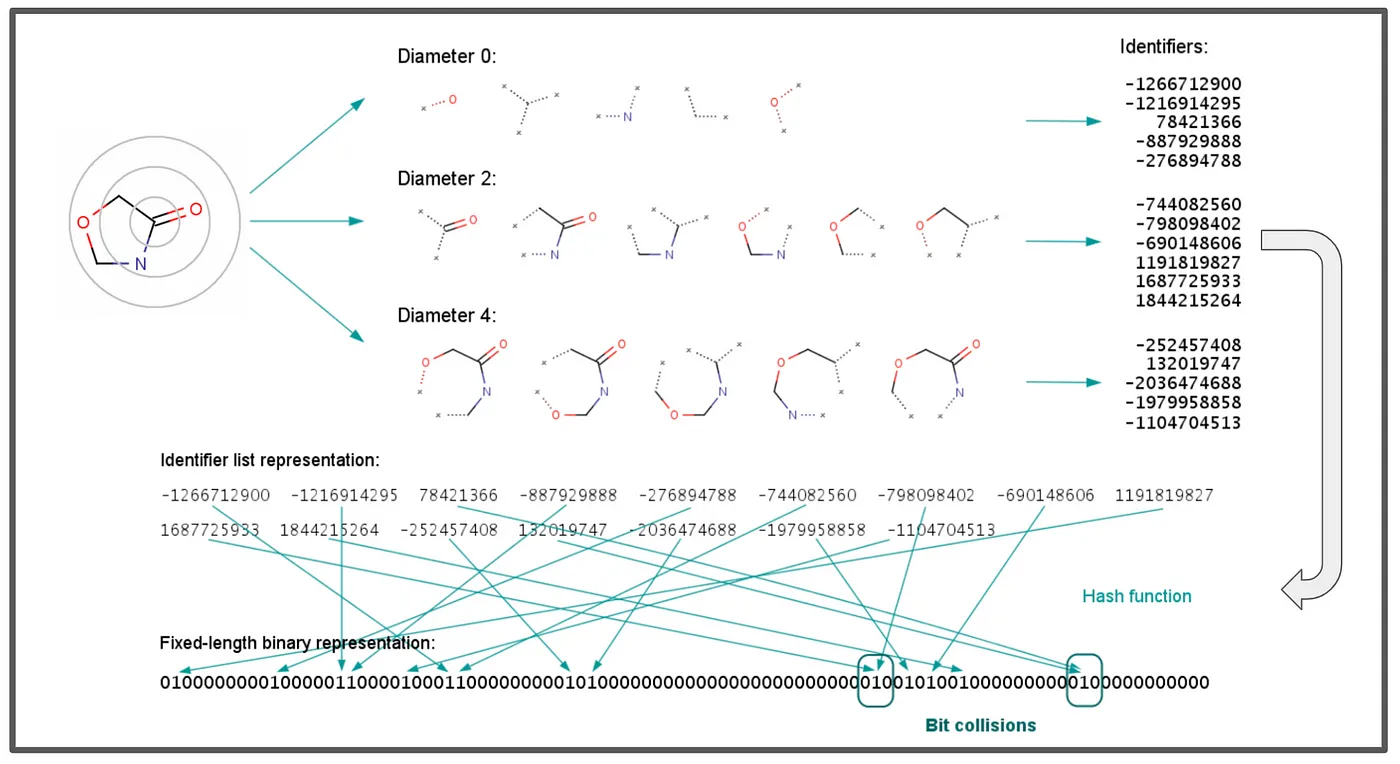

In [16]:
!pip install scikit-learn
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import OneHotEncoder

# Convert SMILES to RDKit molecules
df['molecule'] = df['molecule_smiles'].apply(Chem.MolFromSmiles)

# Generate ECFPs
def generate_ecfp(molecule, radius=2, bits=1024):
    if molecule is None:
        return None
    return list(AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=bits))

df['ecfp'] = df['molecule'].apply(generate_ecfp)


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [17]:
df.head(10)

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds,molecule,ecfp
0,17564856,CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,CCSCCN.Cl,Nc1n[nH]c2c(Cl)cc([N+](=O)[O-])cc12,CCSCCNc1nc(Nc2n[nH]c3c(Cl)cc([N+](=O)[O-])cc23...,BRD4,0,<rdkit.Chem.rdchem.Mol object at 0x320bcb0d0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,35754223,COc1ccc(C[C@H](NC(=O)OCC2c3ccccc3-c3ccccc32)C(...,Nc1ccc(CC2COC(=O)N2)cc1,Nc1nc(Cl)c2[nH]cnc2n1,COc1ccc(C[C@H](Nc2nc(Nc3ccc(CC4COC(=O)N4)cc3)n...,HSA,0,<rdkit.Chem.rdchem.Mol object at 0x320bcb140>,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,131347475,O=C(N[C@H]1CC[C@@H](C(=O)O)C1)OCC1c2ccccc2-c2c...,Cl.NCCNC(=O)c1ccn[nH]1,Nc1nccs1,O=C(NCCNc1nc(Nc2nccs2)nc(N[C@H]2CC[C@@H](C(=O)...,sEH,0,<rdkit.Chem.rdchem.Mol object at 0x320bcb1b0>,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, ..."
3,252829877,O=C(O)C[C@@H](Cc1ccccc1Cl)NC(=O)OCC1c2ccccc2-c...,CC1(CCCCN)OCCO1,COC1(OC)CC(CN)C1,COC1(OC)CC(CNc2nc(NCCCCC3(C)OCCO3)nc(N[C@@H](C...,sEH,0,<rdkit.Chem.rdchem.Mol object at 0x320bcb220>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,73933672,O=C(NC(CCc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,Nc1ccc(OC(F)F)cc1,Cc1ccsc1CN,Cc1ccsc1CNc1nc(Nc2ccc(OC(F)F)cc2)nc(NC(CCc2ccc...,HSA,0,<rdkit.Chem.rdchem.Mol object at 0x320bcb290>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
5,235568363,O=C(O)C1c2ccccc2CN1C(=O)OCC1c2ccccc2-c2ccccc21,COc1cc(CN)c(Br)cn1,Cc1cc(N)ccc1F,COc1cc(CNc2nc(Nc3ccc(F)c(C)c3)nc(N3Cc4ccccc4C3...,sEH,0,<rdkit.Chem.rdchem.Mol object at 0x320bcb300>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,107662743,O=C(N[C@@H](Cc1ccsc1)C(=O)O)OCC1c2ccccc2-c2ccc...,Nc1ccc(Cl)nc1,Nc1cccc2c(=O)[nH][nH]c(=O)c12,O=C(N[Dy])[C@H](Cc1ccsc1)Nc1nc(Nc2ccc(Cl)nc2)n...,BRD4,0,<rdkit.Chem.rdchem.Mol object at 0x320bcb370>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
7,58221505,Cc1ccc(NC(=O)OCC2c3ccccc3-c3ccccc32)c(C(=O)O)c1,Cl.Cl.NCCc1nc2c(s1)COCC2,Cc1cc(N)cc(Cl)c1,Cc1cc(Cl)cc(Nc2nc(NCCc3nc4c(s3)COCC4)nc(Nc3ccc...,HSA,0,<rdkit.Chem.rdchem.Mol object at 0x320bcb3e0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,249049430,O=C(O)C[C@@H](Cc1ccc(F)cc1)NC(=O)OCC1c2ccccc2-...,Cl.NCc1ccnc(C(N)=O)c1,Nc1ccc2cnccc2c1,NC(=O)c1cc(CNc2nc(Nc3ccc4cnccc4c3)nc(N[C@@H](C...,sEH,0,<rdkit.Chem.rdchem.Mol object at 0x320bcb450>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,57497763,Cc1ccc(C[C@H](NC(=O)OCC2c3ccccc3-c3ccccc32)C(=...,Nc1cc(Br)ccc1CO,CN(C)C1(CN)CCSC1,Cc1ccc(C[C@H](Nc2nc(NCC3(N(C)C)CCSC3)nc(Nc3cc(...,BRD4,0,<rdkit.Chem.rdchem.Mol object at 0x320bcb4c0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [18]:
#importing libraries for pipelining and hyperparameter tuning

import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [19]:
# One-hot encode the protein_name
onehot_encoder = OneHotEncoder(sparse_output=False)
protein_onehot = onehot_encoder.fit_transform(df['protein_name'].values.reshape(-1, 1))

# Combine ECFPs and one-hot encoded protein_name
X = [ecfp + protein for ecfp, protein in zip(df['ecfp'].tolist(), protein_onehot.tolist())]
y = df['binds'].tolist()

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probability of the positive class

# Calculate the mean average precision
map_score = average_precision_score(y_test, y_pred_proba)
print(f"Mean Average Precision (mAP): {map_score:.2f}")

Mean Average Precision (mAP): 0.97


In [21]:
len(X_train[0])

1027

In [29]:
y_test

[1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,


In [22]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

# Predictions
y_pred_prob_dt = dt_model.predict_proba(X_test)[:,1]

map_score = average_precision_score(y_test, y_pred_prob_dt)
print(f"Mean Average Precision (mAP): {map_score:.2f}")

Mean Average Precision (mAP): 0.81


In [30]:
y_pred_prob_dt

array([1., 0., 0., ..., 1., 0., 0.])

In [23]:
! pip install xgboost
from xgboost import XGBClassifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:,1]

map_score = average_precision_score(y_test, y_pred_proba_xgb)
print(f"Mean Average Precision (mAP): {map_score:.2f}")


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Mean Average Precision (mAP): 0.97


In [24]:
!pip install catboost
from catboost import CatBoostClassifier
# cat_model = CatBoostClassifier(iterations=1000, learning_rate = 0.01, depth = 13)
cat_model = CatBoostClassifier()
cat_model.fit(X_train, y_train)

# Predictions
y_pred_proba_cat = cat_model.predict_proba(X_test)[:,1]

map_score = average_precision_score(y_test, y_pred_proba_cat)
print(f"Mean Average Precision (mAP): {map_score:.2f}")


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Learning rate set to 0.086011
0:	learn: 0.6626290	total: 104ms	remaining: 1m 43s
1:	learn: 0.6371903	total: 152ms	remaining: 1m 15s
2:	learn: 0.6158599	total: 197ms	remaining: 1m 5s
3:	learn: 0.5956441	total: 249ms	remaining: 1m 2s
4:	learn: 0.5818577	total: 310ms	remaining: 1m 1s
5:	learn: 0.5692952	total: 399ms	remaining: 1m 6s
6:	learn: 0.5575992	total: 479ms	remaining: 1m 7s
7:	learn: 0.5482888	total: 541ms	remaining: 1m 7s
8:	learn: 0.5395643	total: 598ms	remaining: 1m 5s
9:	learn: 0.5313800	total: 661ms	remaining: 1m 5s
10:	learn: 0.5251751	total: 719ms	remaining: 1m 4s
11:	learn: 0.5181504	total: 784ms	remaining: 1m 4s
12:	learn: 0.5122753	total: 845ms	remaining: 1m 4s
13:	learn: 0.5065962	total: 900ms	remaining: 1m 3s
14:	learn: 0.5024175	total: 958ms	remaining: 1m 2s
15:	learn: 0.4983306	total: 1.01s	remaining: 1m 2s
16:	learn: 0.4943436	total: 1.07s	remaining: 1m 1s


In [25]:
from sklearn.neighbors import KNeighborsClassifier
KNN_model = KNeighborsClassifier()
KNN_model.fit(X_train, y_train)

# Predictions
y_pred_proba_KNN = KNN_model.predict_proba(X_test)[:,1]

map_score = average_precision_score(y_test, y_pred_proba_KNN)
print(f"Mean Average Precision (mAP): {map_score:.2f}")

Mean Average Precision (mAP): 0.89


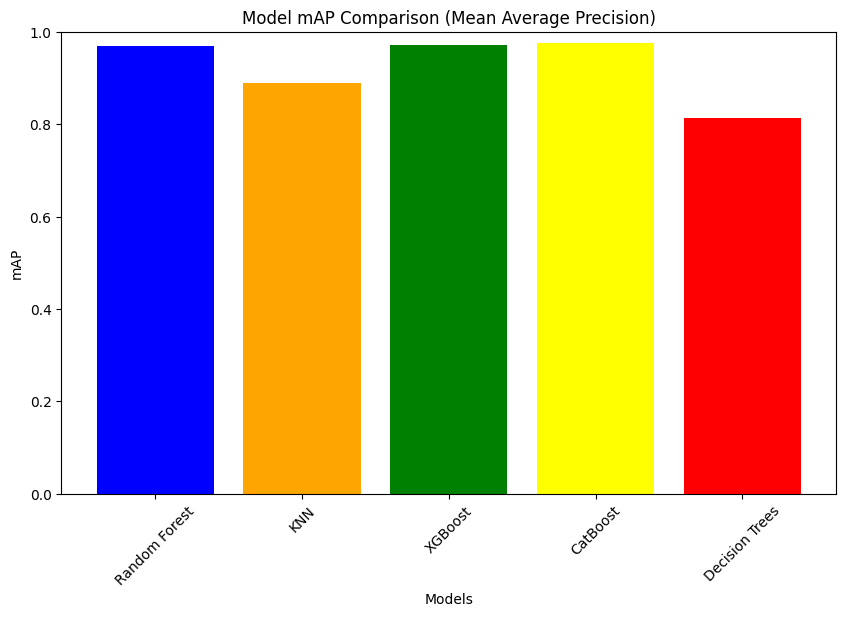

In [26]:
# Calculate accuracy for each model
import matplotlib.pyplot as plt
rf_score =  average_precision_score(y_test, y_pred_proba)
knn_score = average_precision_score(y_test, y_pred_proba_KNN)
xgb_score = average_precision_score(y_test, y_pred_proba_xgb)
cat_score = average_precision_score(y_test,y_pred_proba_cat)
dt_score = average_precision_score(y_test, y_pred_prob_dt)


# Create a bar plot
models = ['Random Forest', 'KNN', 'XGBoost','CatBoost','Decision Trees']
accuracy_scores = [rf_score, knn_score, xgb_score,cat_score,dt_score]

plt.figure(figsize=(10,6))
plt.bar(models, accuracy_scores, color=['blue', 'orange', 'green','yellow','red'])
plt.xlabel('Models')
plt.ylabel('mAP')
plt.title('Model mAP Comparison (Mean Average Precision)')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

We can see that the Catboost, XGBoost and Random Forest models have the highest mAP on the above dataset. This can be seen because part of the Random Forest model is usually more complex than Decision Tree and KNN and at the same time it also avoids overfitting compared to the above two models. Meanwhile, the two Boost models, Catboost and XGBoost, always show outstanding performance in large data sets thanks to their algorithm superiority compared to the two models KNN and Decision Tree.

Therefore, we will experiment with the model with the highest performance, Catboost, to see how it performs on the test set

#  ***Catboost in Test dataset***

In [28]:
import os
import pandas as pd
from rdkit import Chem
from sklearn.preprocessing import OneHotEncoder

# Assumes generate_ecfp and cat_model are already defined and imported
# Assumes onehot_encoder is already fitted and imported

test_file = '../datasets/test.csv'
output_file = '../datasets/submission.csv'

chunksize = 10000  # Process 10,000 rows at a time
max_entries = int(1e5)
processed_entries = 0

# Remove the existing output file if it exists to ensure headers are written correctly
if os.path.exists(output_file):
    os.remove(output_file)

# Read the CSV file in chunks
for chunk in pd.read_csv(test_file, chunksize=chunksize):
    if processed_entries >= max_entries:
        break
    
    # Ensure not to exceed the maximum entries
    chunk = chunk.iloc[:max_entries - processed_entries]

    # Generate ECFPs for the molecule_smiles
    chunk['molecule'] = chunk['molecule_smiles'].apply(Chem.MolFromSmiles)
    chunk['ecfp'] = chunk['molecule'].apply(generate_ecfp)
    chunk = chunk.drop(["buildingblock1_smiles", "buildingblock2_smiles", "buildingblock3_smiles"], axis=1)

    # One-hot encode the protein_name
    protein_onehot = onehot_encoder.transform(chunk['protein_name'].values.reshape(-1, 1))

    # Combine ECFPs and one-hot encoded protein_name
    X_test = [ecfp + protein.tolist() for ecfp, protein in zip(chunk['ecfp'].tolist(), protein_onehot)]

    # Predict the probabilities
    probabilities = cat_model.predict_proba(X_test)[:, 1]

    # Create a DataFrame with 'id' and 'binds' columns
    output_df = pd.DataFrame({'id': chunk['id'], 'binds': probabilities})

    # Save the output DataFrame to a CSV file
    output_df.to_csv(output_file, index=False, mode='a', header=os.path.exists(output_file))

    processed_entries += len(chunk)
